# BME 590 Data Science and Health
## Midterm Project

For the midterm project, you will be putting many of the skills that we have covered in the course so far to create a clinical risk prediction score. Please follow the instructions in this notebook carefully to make sure that you receive full credit for this assignment.

### Background

In 1987, a paper was published in the *Journal of Chronic Disease* titled *A New Method of Classifying Prognostic Comorbidity in Longitudinal Studies: Development and Validation*. This was one of the first papers that created a clinical risk score that could be easily computed and could predict clinical outcomes. To give you an idea of how popular this score is, it has been cited 27,497 times at the time that this assignment was created. As a note, comorbidity describes how many different diseases a patient has. 

In 1987, statistical methods were not as easy to apply as they are today. In addition, data were much harder to come by and to analyze. Due to the improvement of computing power and general statistical practice, it is now much easier to create clinical risk scores than in the past. This will your primary task in this assignment.

## Task 1: Background

Before you begin creating your own version of the Charlson Comorbidity Index, as it is known, it is important to familiarize yourself with the paper. A copy of it can be found [here](http://www.aqc.ch/download/HSM_Suppl_8_charlson.pdf). 

### Answer the following questions:

#### How many patients' data were used to create the model?

training: 559
testing: 685

#### What time frame were the data from?

1 month period in 1984 for admission and 1 year follow-up.

#### How was the model validated?

Applied the model to predict risk of death from comorbid disease of 685 patients who were treated with primary breast cancer and compared with Kaplan and Feinstein method

#### How many patients were used to validate the model results?

 685

#### What were the characteristics of patients in the "Testing population"?

The cohort consisted of all 685 women with histologically proven primary carcinoma of the breast, who received their first treament at Yale New Haven Hospital between 1 Jan 1962 and 31 Dec 1969

___

In the original paper, the conditions listed are not coded in any way. Follow-up papers by [Deyo in 1992](https://www.ncbi.nlm.nih.gov/pubmed/1607900) and [Quan in 2005](https://www.ncbi.nlm.nih.gov/pubmed/16224307), added the ICD-9-CM groupings for the conditions listed in the Charlson Comorbidity Index. In the provided database, a lookup between condition category and code has been provided.

## Task 2: Exploratory Data Analysis and SQL

For this project, the data is located [here](https://duke.box.com/s/vx627f0cypndusbl2k6jyqp9vo33d15g). Please download the database and put it in the same directory as this notebook (or in its own separate directory if you choose). **Make sure you add the database to the provided .gitignore file**. 

### DO NOT COMMIT THE DB FILE

##### Create a connection to the database and complete the following tasks/answer the questions using SQL queries. Remember that you can make a SQL query to the database with the following syntax:

`pd.read_sql(""" YOUR SQL QUERY """, conn)`

In [1]:
import sqlite3 # library for working with sqlite database
conn = sqlite3.connect("mimic_subset.db") # Create a connection to the on-disk database

import pandas as pd

conn

### General

#### List the tables

In [2]:
pd.read_sql("SELECT * FROM sqlite_master where type='table'", conn)

,type,name,tbl_name,rootpage,sql
0,table,admission,admission,2,"CREATE TABLE ""admission"" (\n""index"" INTEGER,\n..."
1,table,diagnosis,diagnosis,1233,"CREATE TABLE ""diagnosis"" (\n""index"" INTEGER,\n..."
2,table,charlson_codes,charlson_codes,4982,"CREATE TABLE ""charlson_codes"" (\n""index"" INTEG..."
3,table,patient,patient,5087,"CREATE TABLE ""patient"" (\n""index"" INTEGER,\n ..."


#### For each table, select a small number of records (rows) and display the columns

In [3]:
pd.read_sql("""SELECT * 
            FROM admission
            limit 1
""", conn)

,index,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,0,2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,None,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,...,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,None,None,BRAIN MASS,0,1


In [4]:
pd.read_sql("""SELECT * 
            FROM diagnosis
            limit 1
""", conn)

,index,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,0,0,1297,109,172335,1.0,40301


In [5]:
pd.read_sql("""SELECT * 
            FROM charlson_codes
            limit 1
""", conn)

,index,code,category
0,0,410,MI


In [6]:
pd.read_sql("""SELECT * 
            FROM patient
            limit 1
""", conn)

,index,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,0,234,249,F,2075-03-13 00:00:00,None,None,None,0


### Patients:

#### What is the breakdown of gender for patients?

In [7]:
pd.read_sql("""SELECT GENDER 
               from patient
""",conn)['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

#### Of the patients in the patients table, how many of them have a death date listed? 

In [8]:
pd.read_sql("""SELECT DOD 
            FROM patient
            WHERE DOD IS NOT NULL""", 
            conn).count()

DOD    15759
dtype: int64

### Admissions:

#### How many unique patients are there in the admissions dataset?

In [9]:
pd.read_sql("""SELECT DISTINCT SUBJECT_ID
               FROM admission
""",conn).count()

SUBJECT_ID    17680
dtype: int64

#### How many unique encounters are there in this dataset?

In [10]:
pd.read_sql("""SELECT DISTINCT HADM_ID
               FROM admission
""",conn).count()

HADM_ID    21879
dtype: int64

#### How many encounters have an ED time (either registration or out) listed?

In [11]:
pd.read_sql("""select HADM_ID, EDREGTIME, EDOUTTIME 
               from admission 
               where EDREGTIME is not null or EDOUTTIME is not null
               group by HADM_ID""",conn).count()

HADM_ID      14495
EDREGTIME    14495
EDOUTTIME    14495
dtype: int64

#### List the primary diagnoses (Diagnosis field) in order of their prevalence

In [12]:
pd.read_sql("""select DIAGNOSIS, count(DIAGNOSIS) number_of_diagnosis
               from admission
               group by DIAGNOSIS
               order by number_of_diagnosis desc
               limit 10
""",conn)

,DIAGNOSIS,number_of_diagnosis
0,PNEUMONIA,969
1,SEPSIS,501
2,ALTERED MENTAL STATUS,477
3,INTRACRANIAL HEMORRHAGE,441
4,CONGESTIVE HEART FAILURE,418
5,UPPER GI BLEED,385
6,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,378
7,CHEST PAIN,353
8,ABDOMINAL PAIN,313
9,CORONARY ARTERY DISEASE,302


#### Now list the count of diagnoses along with the diagnosis name only for patients who died in their hospital stay in descending order

In [13]:
pd.read_sql("""select DIAGNOSIS, count(DIAGNOSIS) number_of_diagnosis
               from admission
               where DEATHTIME<=dischtime
               group by DIAGNOSIS
               order by number_of_diagnosis desc
""",conn)

,DIAGNOSIS,number_of_diagnosis
0,PNEUMONIA,149
1,INTRACRANIAL HEMORRHAGE,137
2,SEPSIS,100
3,ALTERED MENTAL STATUS,54
4,CONGESTIVE HEART FAILURE,49
5,STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,44
6,CARDIAC ARREST,39
7,ABDOMINAL PAIN,37
8,HYPOTENSION,32
9,S/P FALL,32


### Charlson Codes:

#### How many categories are there? 

In [14]:
pd.read_sql("""select distinct category 
            from charlson_codes
""", conn).count()

category    17
dtype: int64

### Diagnoses

#### What is the minimum, average, and maximum count of codes that is given to a patient at a particular encounter?

In [15]:
# pd.read_sql("""SELECT SUBJECT_ID, HADM_ID, count(ICD9_CODE) as number_of_codes
#                FROM diagnosis
#                group by HADM_ID
#                order by number_of_codes
# """, conn)

In [16]:
pd.read_sql("""select min(count_of_codes),avg(count_of_codes),max(count_of_codes) from
             (
               SELECT SUBJECT_ID, HADM_ID, count(ICD9_CODE) as count_of_codes
               FROM diagnosis
               group by HADM_ID
              )
""", conn)

,min(count_of_codes),avg(count_of_codes),max(count_of_codes)
0,1,14.632936,39


### Combined information

#### There is a `DEATHTIME` column in the admission table. In addition, there is death information present in the patient table. Is the information in the admission table complete? (Are there patients who have death information in the patient table who do not have the same information in the admissions table?)

In [17]:
pd.read_sql("""select SUBJECT_ID, DEATHTIME, DOD from
              (
               select * 
               from patient
               LEFT JOIN  admission ON admission.SUBJECT_ID = patient.SUBJECT_ID
               )
               where DOD is not null and DEATHTIME is null
""", conn).head()

,SUBJECT_ID,DEATHTIME,DOD
0,250,None,2188-11-22 00:00:00
1,257,None,2121-07-08 00:00:00
2,261,None,2102-06-29 00:00:00
3,263,None,2168-06-13 00:00:00
4,268,None,2198-02-18 00:00:00


### Answer: the information in the admission table is not complete 

#### Join the diagnosis and the Charlson tables together by code and list the Charlson Categories and their counts in descending order

In [18]:
pd.read_sql("""select category,count(category) from
                (
               SELECT *
               FROM diagnosis
               LEFT JOIN charlson_codes ON diagnosis.ICD9_CODE = charlson_codes.code   
               )
               group by category
               order by count(category) desc
""", conn)

,category,count(category)
0,CHF,11347
1,Pulmonary,6402
2,Renal,6209
3,DM,5295
4,Stroke,4041
5,MI,3457
6,LiverMild,3407
7,PVD,2918
8,Mets,2902
9,Cancer,2901


## Task 3: Visualization

For this task, you can use pandas along with any plotting library that we've learned about to create the following visualizations. You may have to create a separate dataframe specifically for each of these plots.

> One important concept in hospital care is the Length of Stay for a patient. In general, the longer a patient stays, the more severe their case. There are many initiatives to try and reduce the length of stay. 

#### Create a length of stay (in days) column in the dataframe. The Length of Stay is defined as the discharge time minus the admission time. 

For this, you will need to use the `.dt.days` accessor as seen [here](https://stackoverflow.com/a/45039811)

In [19]:
df = pd.read_sql("select * from admission", conn)

In [20]:
import datetime as dt
import numpy as np

# df1['length_of_stay'] = np.float64(df1['discharge_time'] - df1['admit_time'])/(3600*24*1000000000)

df['length_of_stay'] = ( pd.to_datetime(df['DISCHTIME']) - pd.to_datetime(df['ADMITTIME']) ).dt.days

df[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','length_of_stay']]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,length_of_stay
0,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,6
1,34,144319,2191-02-23 05:23:00,2191-02-25 20:20:00,2
2,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,10
3,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,3
4,357,117876,2199-12-21 22:37:00,2200-01-18 11:45:00,27
5,85,112077,2167-07-25 18:49:00,2167-07-30 15:24:00,4
6,107,182383,2121-11-30 19:24:00,2121-12-05 14:18:00,4
7,107,174162,2122-05-14 19:37:00,2122-05-18 15:11:00,3
8,109,147469,2141-06-11 10:17:00,2141-06-17 16:29:00,6
9,124,138376,2165-12-31 18:55:00,2166-02-01 06:55:00,31


#### Create a plot which contains boxplots that contain the length of stay information, broken down by Admission Type

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

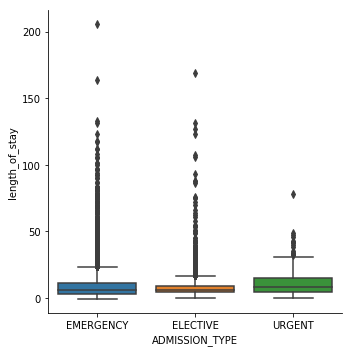

In [22]:
sns.catplot(x="ADMISSION_TYPE", y="length_of_stay", data=df, kind="box");

#### Create a scatter plot which has the length of stay in days on one axis 
#### and the number of diagnosis codes for a particular encounter on the other

In [23]:
df_new = pd.read_sql("""select SUBJECT_ID, HADM_ID, DISCHTIME, ADMITTIME, count(ICD9_CODE) as nbr_of_diag_code
                     from(
                     SELECT *
                     FROM admission
                     LEFT JOIN diagnosis ON diagnosis.HADM_ID = admission.HADM_ID
                     )
                     group by HADM_ID
""", conn)

In [24]:
df_new['length_of_stay'] = ( pd.to_datetime(df_new['DISCHTIME']) - pd.to_datetime(df_new['ADMITTIME']) ).dt.days

In [25]:
# sns.scatterplot(x="length_of_stay", y="nbr_of_diag_code", data=df1)

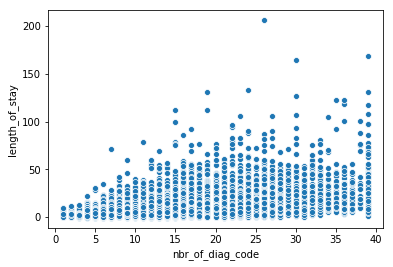

In [26]:
sns.scatterplot(x="nbr_of_diag_code", y="length_of_stay", data=df_new)

#### Ask your own question about the data and answer it with a visualization of your choice
###### Create a plot which contains boxplots that contain the length of stay information, broken down by INSURANCE¶

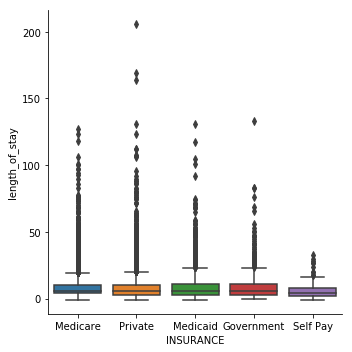

In [27]:
sns.catplot(x="INSURANCE", y="length_of_stay", data=df, kind="box");

## Task 4: Create the Design/Model matrix 

For this task, you will create the Design/Model matrix for your clinical risk score. Each row should pertain to a unique encounter, and the columns should be each of the categories available in the `charlson_codes` table. 

In particular, you will need to detect the presence of an ICD-code that belongs to a category in the Charlson Comorbidity Index, and make the corresponding entry a 1 if it is present, and a 0 if it is not. 

In addition, you should create a column that contains the value 1.0 repeated to represent the intercept weight. 

Finally, you will need 1 column that represents whether a patient's death date is within 1 year of their encounter `ADMITTIME`.

Below are a list of steps that can walk you through the process. You do not need to necessarily follow these steps, but at the end you should end up with a matrix that looks something like this (with all of the category columns)


##### As a DataFrame

In [28]:
example_df = pd.DataFrame({'Intercept': [1,1,1], 'CHF': [1, 0, 0], 'MI': [1, 1, 0], 'Stroke': [0, 0, 0], '1_yr_mortality': [1, 0, 0]})
example_df

,Intercept,CHF,MI,Stroke,1_yr_mortality
0,1,1,1,0,1
1,1,0,1,0,0
2,1,0,0,0,0


##### As a Numpy array

In [29]:
example_df.values

array([[1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]])

### Recommended Steps for Creating the Design Matrix

For this task, you will need to use the `admission`, `diagnosis`, `charlson_codes`, and `patient` tables. 

To get an accurate death date at the encounter level, join the patient table into the admission table by patient identifier. From there, create a new column that determines whether there has been 1 year or less between the mortality(death) date and the admission time. 

Remember that when working with datetime columns, you will need to utilize the `pd.to_datetime` function. You can subtract times and use the `.dt.days` method to extract the number of days. [Reference](https://stackoverflow.com/a/45039811)

In [30]:
df1 = pd.read_sql("""select subject_id, hadm_id, admittime, dod
                        from(
                        select * 
                        from admission
                        left join patient on patient.subject_id=admission.subject_id
                        )
                        """,conn)

In [31]:
df1['b'] = ( pd.to_datetime(df1['DOD']) - pd.to_datetime(df1['ADMITTIME']) ).dt.days

# df1['1_yr_mortality'] = [0 if ('b'==np.nan) | (df1['b'] > 365) else 1]

df1['1_yr_mortality'] = np.where(df1.b.isnull(), 0, np.where(df1.b >365, 0, 1))    
df1 = df1[['SUBJECT_ID','HADM_ID','1_yr_mortality']]   

Next, join the `diagnosis` and `charlson_codes` data together. If there is missing information, use the type of join that removes missing information. Not all diagnosis codes map to an existing Charlson category. 

In [32]:
df2 = pd.read_sql("""SELECT *
                     FROM diagnosis
                     inner JOIN charlson_codes ON diagnosis.ICD9_CODE = charlson_codes.code   
""",conn)

Once you have this new DataFrame, you will notice that it is in a long format. You will need to turn it into a wide format so that each category is represented as its own column. You can start with this command to get started:

`.groupby(['id', 'category']).size().unstack()`

In [33]:
df3 = df2.groupby(['HADM_ID', 'category']).size().unstack()

You will also need to binarize (turn to 1s and 0s) each of the category columns. 

In [34]:
df4 = df3
df4 = df3.fillna(0)
df4[df4 != 0] = 1

Merge all of the data together so that it looks like the example above.

In [35]:
df5 = df4
df5['Intercept'] =1

In [36]:
df6 = pd.merge(df5,
               df1,
               on = 'HADM_ID',
               how='left')
df6.shape

(18027, 21)

In [37]:
df7=df6.loc[:,['Intercept','MI','CHF','PVD','Stroke','Dementia','Pulmonary','Rheumatic','PUD','LiverMild','DM','DMcx','Paralysis','Renal','Cancer','LiverSevere','Mets','HIV','1_yr_mortality']]
df7.head()

,Intercept,MI,CHF,PVD,Stroke,Dementia,Pulmonary,Rheumatic,PUD,LiverMild,DM,DMcx,Paralysis,Renal,Cancer,LiverSevere,Mets,HIV,1_yr_mortality
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0


# Task 5: Fit a logistic regression model via gradient descent

Implement the gradient ascent algorithm and use it to iteratively update some initialized weights for your logistic regression. For this step, do not use an implementation in another library (sklearn, statsmodels). You must write your own implementation using base python, numpy, and other standard libraries. If you have a question about what is allowed, please ask one of the instructors.

Recall that the average loss can be expressed as follows (this is usually displayed with a negative sign out front)

$$\frac{1}{m}\sum_{i=1}^{m}y^{(i)} \log \sigma(\textbf{w}^T\textbf{x}^{(i)}) + (1-y^{(i)}) \log (1- \sigma(\textbf{w}^T\textbf{x}^{(i)}) $$

The Gradient Ascent update equation is given by: 
$$ w_j \leftarrow w_j + \alpha(y-\sigma(\textbf{w}^T\textbf{x}))x_j $$

where $\alpha$ is a learning rate which affects the speed of convergence. 

The pseudocode to fit a logistic regression model looks similar to the following:
```    
Repeat {

  1. Calculate average gradient value over the dataset(for all x_j)
  2. Multiply by the average gradient by the learning rate
  3. Update the weights by adding this value to the original weights

}
```

It is recommended that you have helper functions to perform the logistic function and the calculation of the gradient

In [39]:
def predict(x, w):
    z = np.dot(x, w)    
    return 1/(1+np.exp(-z))

In [40]:
def logistic_loss(x, y, w):
    
    N = len(x)
    loss = 0 
    
    for i in range(N):
        predictions = predict(x[i],w)
        loss += y[i]*np.log(predictions) + (1-y[i])*np.log(1-predictions)
        
    loss = loss/N
    
    return loss

In [41]:
def get_gradient(x, y, w):

    N = len(x)
    predictions = predict(x, w)
    gradient = np.dot(  x.T, (predictions - y) ) /N

    return gradient

In practice, you will want to initialize an array of weights w of the appropriate size with all 0s or some other small random value. Then, you will follow the pseudocode above, and update the weights iteratively. At each step, you will want to compute the value $y - \sigma(\textbf{w}^T\textbf{x})x_j$ over all of the rows of the matrix and find the average value over the entire dataset. Then apply the learning rate and update the weights according to the update equation above.

In [42]:
features = x[:,0:18]
labels = x[:,18]

N = len(features)
lr = 1

In [43]:
weights = np.zeros(18) # init weights to some random value.
iters = 1000 # set this to the number of iterations
    
for i in range(iters):
    gradient = get_gradient(features, labels, weights)
    weights -= lr*gradient
    loss = logistic_loss(features, labels, weights)
    if(i%100==0):
        print('weights = ', weights)  
        print('loss = ', -loss)
        print('  ')
        print('  ')

weights =  [-0.19418095 -0.03758252 -0.0452377  -0.02801354 -0.02762523 -0.00077661
 -0.06121373 -0.00815444 -0.00793255 -0.02013646 -0.06495812 -0.01841682
 -0.00718367 -0.02951129  0.00504798 -0.00138681  0.01550452 -0.00227437]
loss =  0.6500860082848143
  
  
weights =  [-1.44839954 -0.07133369  0.51140832  0.00188471  0.3142176   0.3744167
  0.02019655  0.00587733 -0.08224529  0.27910201 -0.15735518 -0.24638442
  0.13934137  0.50233585  0.902912    0.51542595  1.27959613 -0.04395181]
loss =  0.5569043649597789
  
  
weights =  [-1.67551136 -0.02078871  0.60201353  0.06401068  0.44535479  0.64397152
  0.08976448  0.0653997  -0.07535141  0.36477204 -0.10215399 -0.2850764
  0.2447225   0.57245295  0.97309844  0.71910724  1.60507033 -0.05376001]
loss =  0.5531476000660571
  
  
weights =  [-1.74658422 -0.0024647   0.62796314  0.08601332  0.47290369  0.80969074
  0.11223386  0.10516375 -0.06339762  0.37877927 -0.08551341 -0.28753293
  0.29978778  0.58829843  0.98497942  0.80490379  1.7

You will want to repeat this procedure until the algorithm converges. You can play around with the learning rate and the number of total iterations for this program to converge either faster or slower. In addition, you can choose to use other versions of gradient descent, such as mini-batch gradient descent and/or stochastic gradient descent to improve the convergence rate. One way to check for convergence is to check to make sure that the weights are not changing by a certain small threshold. Another way is to run for a number of iterations and check against the `statsmodels` implementation:

```
from statsmodels import api as sm

logit = sm.Logit(y, X)
logit.fit().params
```

In [44]:
from statsmodels import api as sm

logit = sm.Logit(labels, features)
logit.fit().params


Optimization terminated successfully.
         Current function value: 0.552290
         Iterations 5


array([-1.79681149,  0.00971758,  0.64501572,  0.1027442 ,  0.47533345,
        1.03639994,  0.12806205,  0.15301175, -0.0387222 ,  0.37496309,
       -0.07446433, -0.27682168,  0.36273724,  0.59364506,  0.99381556,
        0.88318575,  1.78530929, -0.03785321])

### I have checked and think my first method works well.